## Single-cancer holdout analysis

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

Here, we want to look at experiments where a single cancer type is held out. We want to compare cross-validation results when models are trained only on data from a single cancer type with results when models are trained on data from all cancer types.

In the following plots, each point is a gene/cancer type combination (rather than the stratified experiments, where each point is a gene and the test set is a combination of different cancer types).

(All of these experiments use the Vogelstein genes, since this gene set seemed to capture more relevant signal in the stratified CV results)

In [2]:
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
pancancer_dir2 = os.path.join(cfg.results_dir, 'vogelstein_s1_results', 'pancancer')
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')
single_cancer_dir2 = os.path.join(cfg.results_dir, 'vogelstein_s1_results', 'single_cancer')

In [3]:
single_cancer_df1 = au.load_prediction_results(single_cancer_dir, 'single_cancer')
single_cancer_df2 = au.load_prediction_results(single_cancer_dir2, 'single_cancer')
single_cancer_df = pd.concat((single_cancer_df1, single_cancer_df2))
print(np.unique(single_cancer_df.seed))
print(single_cancer_df.shape)
single_cancer_df.head()

[ 1 42]
(20772, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.99987,0.99879,MAP3K1,BRCA,signal,42,train,0,single_cancer,MAP3K1_BRCA
1,0.72689,0.46638,MAP3K1,BRCA,signal,42,test,0,single_cancer,MAP3K1_BRCA
2,0.72844,0.38910,MAP3K1,BRCA,signal,42,cv,0,single_cancer,MAP3K1_BRCA
3,0.99860,0.98630,MAP3K1,BRCA,signal,42,train,1,single_cancer,MAP3K1_BRCA
4,0.74887,0.48700,MAP3K1,BRCA,signal,42,test,1,single_cancer,MAP3K1_BRCA


In [4]:
pancancer_df1 = au.load_prediction_results(pancancer_dir, 'pancancer')
pancancer_df2 = au.load_prediction_results(pancancer_dir2, 'pancancer')
pancancer_df = pd.concat((pancancer_df1, pancancer_df2))
print(np.unique(pancancer_df.seed))
print(pancancer_df.shape)
pancancer_df.head()

[ 1 42]
(20784, 10)


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,train_set,identifier
0,0.95820,0.68399,MAP3K1,BRCA,signal,42,train,0,pancancer,MAP3K1_BRCA
1,0.69619,0.40796,MAP3K1,BRCA,signal,42,test,0,pancancer,MAP3K1_BRCA
2,0.62527,0.20878,MAP3K1,BRCA,signal,42,cv,0,pancancer,MAP3K1_BRCA
3,0.98367,0.82884,MAP3K1,BRCA,signal,42,train,1,pancancer,MAP3K1_BRCA
4,0.77170,0.44885,MAP3K1,BRCA,signal,42,test,1,pancancer,MAP3K1_BRCA


First, we want to see which gene/cancer type combinations we can use to successfully build a classifier; i.e. which combinations perform significantly better than the negative control with shuffled labels.

We expect many of these genes to be the same ones that we identified in the stratified analysis, but we're also interested in genes that are identified in this analysis but not the stratified analysis (i.e. genes where we can build a good classifier in a particular cancer type, but the classifier does not generalize well across cancer types).

In [5]:
single_cancer_comparison_df = au.compare_results(single_cancer_df,
                                                 identifier='identifier',
                                                 metric='aupr',
                                                 correction=True,
                                                 correction_alpha=0.001,
                                                 verbose=False)
single_cancer_comparison_df.sort_values(by='corr_pval').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
133,EGFR_HNSC,0.661297,2.092342e-16,8.160134e-14,True
51,ATRX_LGG,0.719961,4.924283e-16,9.602352e-14,True
190,IDH1_LGG,0.468498,2.856960e-15,3.714047e-13,True
145,ERBB2_BRCA,0.680855,8.417854e-14,8.207408e-12,True
314,PTEN_UCEC,0.725630,1.190876e-13,8.947625e-12,True
374,TP53_LGG,0.524859,1.376558e-13,8.947625e-12,True
72,BRAF_THCA,0.682111,2.747315e-13,1.530647e-11,True
125,CTNNB1_UCEC,0.719790,3.832747e-13,1.868464e-11,True
360,SPOP_PRAD,0.740886,8.537779e-13,3.027031e-11,True
5,APC_COAD,0.727701,8.513758e-13,3.027031e-11,True


Text(0.5, 1.0, 'Train single cancer/test single cancer, Vogelstein et al. cancer genes')

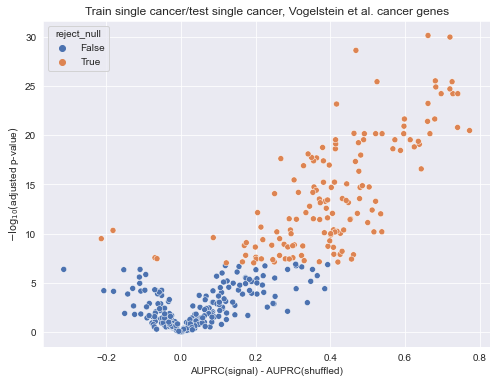

In [6]:
# volcano plot like in the previous analysis, but for gene/holdout cancer type combinations
# (instead of individual genes as before)
single_cancer_comparison_df['nlog10_p'] = -np.log(single_cancer_comparison_df.corr_pval)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=single_cancer_comparison_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.xlabel('AUPRC(signal) - AUPRC(shuffled)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Train single cancer/test single cancer, Vogelstein et al. cancer genes')

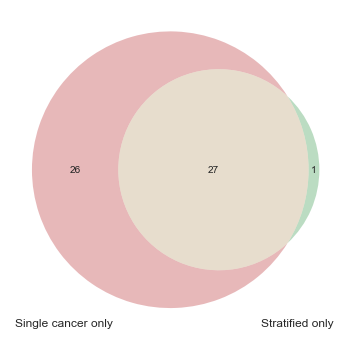

In [7]:
# get genes that are significant in single cancer holdout analysis
sig_ids = single_cancer_comparison_df[
    single_cancer_comparison_df.reject_null
].identifier.values
sig_genes = list(set([id_str.split('_')[0] for id_str in sig_ids]))

# then get overlap with genes that are significant in stratified analysis
vogelstein_results_df = pd.read_csv(os.path.join(cfg.results_dir, 'vogelstein_stratified_pvals.tsv'),
                                    sep='\t')
sig_genes_stratified = vogelstein_results_df[
    vogelstein_results_df.reject_null
].identifier.values

# then plot results in a venn diagram
def get_venn(g1, g2):
    s1, s2 = set(g1), set(g2)
    s_inter = list(s1 & s2)
    s1_only = list(s1 - s2)
    s2_only = list(s2 - s1)
    return ((s1_only, s2_only, s_inter),
            (len(s1_only), len(s2_only), len(s_inter)))

venn_sets, venn_counts = au.get_venn(sig_genes, sig_genes_stratified)
v = venn2(subsets=venn_counts, set_labels=('Single cancer only', 'Stratified only', 'Both'))
v.get_label_by_id('A').set_y(-0.6)
v.get_label_by_id('B').set_y(-0.6)
v.get_label_by_id('A').set_x(-0.3)
v.get_label_by_id('B').set_x(0.3)

In [8]:
# print genes (and cancer types in holdout analysis) that are not in the intersection
holdout_only_genes = venn_sets[0]
disjoint_identifiers_df = single_cancer_comparison_df[
    (single_cancer_comparison_df.reject_null) &
    (single_cancer_comparison_df.identifier.str.startswith(tuple(holdout_only_genes)))
].sort_values(by='corr_pval').reset_index(drop=True)
print(venn_sets[1])
disjoint_identifiers_df.head(n=15)

['JAK3']


,identifier,delta_mean,p_value,corr_pval,reject_null,nlog10_p
0,TSC1_BLCA,0.596976,3.588608e-11,8.232689e-10,True,20.917738
1,CDH1_BRCA,0.463298,8.750714e-11,1.706389e-09,True,20.188886
2,SETD2_KIRC,0.613607,2.200979e-10,3.269545e-09,True,19.538615
3,KIT_TGCT,0.643104,7.936246e-09,6.316604e-08,True,16.577499
4,KDM6A_BLCA,0.356362,5.808941e-08,3.974538e-07,True,14.738187
5,FUBP1_LGG,0.503891,5.732177e-08,3.974538e-07,True,14.738187
6,PPP2R1A_UCEC,0.362420,8.490534e-08,5.518847e-07,True,14.409927
7,SETD2_LUAD,0.250922,1.263476e-07,7.821520e-07,True,14.061217
8,NF1_GBM,0.432105,2.113039e-07,1.287633e-06,True,13.562705
9,IDH2_STAD,0.478189,2.155352e-07,1.293211e-06,True,13.558382


Now we can do the same thing using pan-cancer data (i.e. train the model on all cancer types, and test on held-out data from a single cancer type). These results should be similar to the single-cancer results, but due to the additional data we should be better powered to identify certain effects (e.g. in relatively rare cancer types) and other effects (single cancer-specific effects) should be washed out due to the addition of the pan-cancer data.

We'll attempt to identify these later.

In [9]:
pancancer_comparison_df = au.compare_results(pancancer_df,
                                             identifier='identifier',
                                             metric='aupr',
                                             correction=True,
                                             correction_alpha=0.001,
                                             verbose=False)
pancancer_comparison_df.sort_values(by='corr_pval').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
52,ATRX_LGG,0.728086,1.108531e-16,4.356526e-14,True
21,ARID1A_STAD,0.586525,3.460328e-14,4.463081e-12,True
126,CTNNB1_UCEC,0.713087,4.542576e-14,4.463081e-12,True
10,APC_READ,0.824603,4.371540e-14,4.463081e-12,True
317,PTEN_UCEC,0.734057,9.456855e-14,7.433088e-12,True
269,NRAS_SKCM,0.648199,1.306928e-13,8.560376e-12,True
146,ERBB2_BRCA,0.679413,2.049272e-13,1.150520e-11,True
73,BRAF_THCA,0.691114,5.219604e-13,2.279227e-11,True
375,TP53_HNSC,0.440071,5.107836e-13,2.279227e-11,True
134,EGFR_HNSC,0.607141,7.502686e-13,2.948555e-11,True


Text(0.5, 1.0, 'Train pan-cancer/test single cancer, Vogelstein et al. cancer genes')

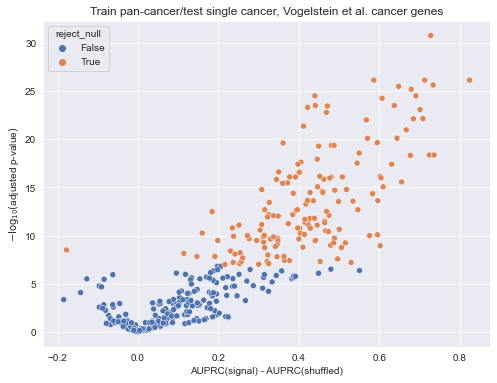

In [10]:
# TODO: Venn diagram of genes significant for stratified analysis vs. new genes
pancancer_comparison_df['nlog10_p'] = -np.log(pancancer_comparison_df.corr_pval)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=pancancer_comparison_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.xlabel('AUPRC(signal) - AUPRC(shuffled)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Train pan-cancer/test single cancer, Vogelstein et al. cancer genes')

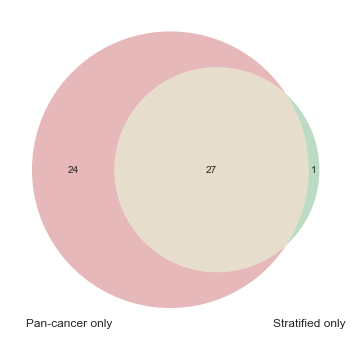

In [11]:
# get genes that are significant in single cancer holdout analysis
sig_ids = pancancer_comparison_df[
    pancancer_comparison_df.reject_null
].identifier.values
sig_genes = list(set([id_str.split('_')[0] for id_str in sig_ids]))

# then get overlap with genes that are significant in stratified analysis
sig_genes_stratified = vogelstein_results_df[
    vogelstein_results_df.reject_null
].identifier.values

# then plot results in a venn diagram
venn_sets, venn_counts = au.get_venn(sig_genes, sig_genes_stratified)
v = venn2(subsets=venn_counts, set_labels=('Pan-cancer only', 'Stratified only', 'Both')) 
v.get_label_by_id('A').set_y(-0.6)
v.get_label_by_id('B').set_y(-0.6)
v.get_label_by_id('A').set_x(-0.3)
v.get_label_by_id('B').set_x(0.35)

In [12]:
# print genes (and cancer types in holdout analysis) that are not in the intersection
holdout_only_genes = venn_sets[0]
disjoint_identifiers_df = pancancer_comparison_df[
    (pancancer_comparison_df.reject_null) &
    (pancancer_comparison_df.identifier.str.startswith(tuple(holdout_only_genes)))
].sort_values(by='corr_pval').reset_index(drop=True)
print(venn_sets[1])
disjoint_identifiers_df.head(n=15)

['JAK2']


,identifier,delta_mean,p_value,corr_pval,reject_null,nlog10_p
0,CDH1_BRCA,0.481028,2.546034e-10,3.848429e-09,True,19.375601
1,KIT_TGCT,0.604547,1.377343e-08,1.127699e-07,True,15.997916
2,KDM6A_BLCA,0.344424,1.723782e-08,1.328326e-07,True,15.834176
3,TSC1_BLCA,0.459864,8.180635e-08,5.185467e-07,True,14.472236
4,SOX9_COAD,0.386160,8.958480e-08,5.588385e-07,True,14.397405
5,NF1_LGG,0.534866,2.193561e-07,1.267749e-06,True,13.578268
6,H3F3A_BRCA,0.184442,7.314413e-07,3.733200e-06,True,12.498245
7,SETD2_KIRC,0.415143,1.825586e-06,8.342504e-06,True,11.694147
8,FUBP1_LGG,0.415147,2.551872e-06,1.126838e-05,True,11.393510
9,NF1_OV,0.464299,2.742008e-06,1.184186e-05,True,11.343870


Now, we want to compare results when models are trained on single-cancer data to results for the same cancer type, trained on pan-cancer data. That is, we want to identify examples where pan-cancer models perform significantly better than single-cancer models (not just better than the control), and vice-versa - examples where single-cancer models perform significantly better will also be interesting.

In [13]:
experiment_comparison_df = au.compare_results(single_cancer_df,
                                              pancancer_df=pancancer_df,
                                              identifier='identifier',
                                              metric='aupr',
                                              correction=True,
                                              correction_alpha=0.05,
                                              verbose=False)
experiment_comparison_df.sort_values(by='corr_pval').head(n=15)

,identifier,delta_mean,p_value,corr_pval,reject_null
349,SMAD4_HNSC,0.319513,0.000004,0.001648,True
25,FBXW7_LUSC,0.317024,0.000127,0.027420,True
86,ARID1A_STAD,0.110541,0.000184,0.027420,True
324,KDM5C_KIRC,-0.349511,0.000394,0.039537,True
440,NF1_SARC,0.405654,0.000442,0.039537,True
395,NF1_BLCA,0.201823,0.000560,0.041698,True
21,JAK2_UCEC,0.394205,0.000854,0.054526,False
245,BRAF_SKCM,-0.186559,0.001091,0.059650,False
399,PPP2R1A_UCS,0.273885,0.001201,0.059650,False
240,NF1_UCEC,0.210298,0.001533,0.063753,False


Text(0.5, 1.0, 'Comparison of pan-cancer and single-cancer results, Vogelstein genes')

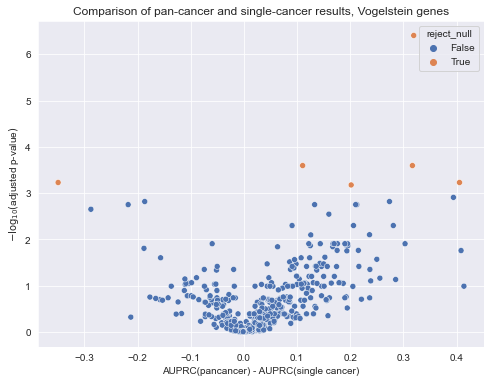

In [14]:
experiment_comparison_df['nlog10_p'] = -np.log(experiment_comparison_df.corr_pval)

sns.set({'figure.figsize': (8, 6)})
sns.scatterplot(data=experiment_comparison_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.xlabel('AUPRC(pancancer) - AUPRC(single cancer)')
plt.ylabel(r'$-\log_{10}($adjusted p-value$)$')
plt.title('Comparison of pan-cancer and single-cancer results, Vogelstein genes')

In [15]:
# save some data to be used elsewhere
single_cancer_comparison_df.to_csv(os.path.join(cfg.results_dir, 'single_cancer_pvals.tsv'), index=False, sep='\t')
pancancer_comparison_df.to_csv(os.path.join(cfg.results_dir, 'pancancer_pvals.tsv'), index=False, sep='\t')